In [2]:
# bibliotecas para a analise dos abstracts
!pip install pandas nltk wordcloud matplotlib yake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.1 MB/s eta 0:00:00


In [4]:
import pandas as pd
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# fazendo download dos dados
!wget https://raw.githubusercontent.com/brasileiras-pln/analise-acl-2023/main/abstracts_acl2023.csv

--2023-12-20 09:26:24--  https://raw.githubusercontent.com/brasileiras-pln/analise-acl-2023/main/abstracts_acl2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6650170 (6.3M) [text/plain]
Saving to: ‘abstracts_acl2023.csv.1’

abstracts_acl2023.c 100%[===================>]   6.34M  --.-KB/s    in 0.1s    

2023-12-20 09:26:24 (58.0 MB/s) - ‘abstracts_acl2023.csv.1’ saved [6650170/6650170]



In [5]:
data_file = "abstracts_acl2023.csv"
df = pd.read_csv(data_file, header=None, names=['Abstract'],on_bad_lines='skip')

In [6]:
print(df.shape)

(6764, 1)


In [7]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Tokenize and remove stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if isinstance(text, str):
        words = nltk.word_tokenize(text)
        words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
        return ' '.join(words)
    else:
        return ''


df['Processed_Abstract'] = df['Abstract'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(df.head())

                                            Abstract  \
0  We present a summary of the efforts to improve...   
1  User simulators are agents designed to imitate...   
2  One of the main challenges open-domain end-to-...   
3  While the problem of hallucinations in neural ...   
4  Explainable recommendation is a technique that...   

                                  Processed_Abstract  
0  present summary efforts improve conference pee...  
1  user simulators agents designed imitate human ...  
2  one main challenges dialogue systems chatbots ...  
3  problem hallucinations neural machine translat...  
4  explainable recommendation technique combines ...  


In [4]:
# aqui nós temos uma word cloud simples
all_text = ' '.join(df['Processed_Abstract'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud.to_file("/content/drive/MyDrive/acl-data-2023/word_cloud.png")

NameError: ignored

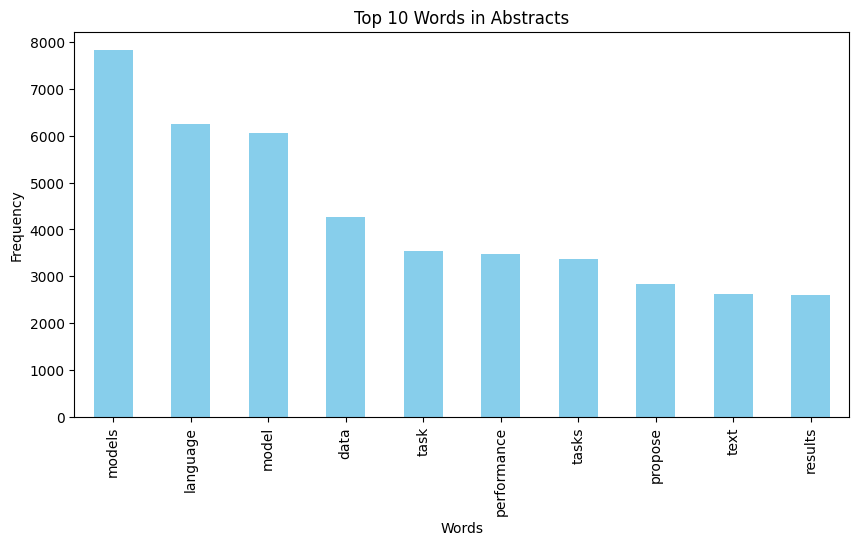

In [ ]:
# as top-10 palavras (unigramas)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['Processed_Abstract'])
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_words = word_freq.sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
top_words.plot(kind='bar', color='skyblue')
plt.title('Top 10 Palavras nos Resumos')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()





# Análise de Bigrama

In [ ]:
# aqui fazemos uma análise das top-20 bigramas
import cufflinks as cf


def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['Processed_Abstract'], 20)

for word, freq in common_words:
    print(word, freq)

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

df4 = pd.DataFrame(common_words, columns = ['Processed_Abstract' , 'count'])
df4.groupby('Processed_Abstract').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigramas', asFigure=True).show(renderer="colab")


language models 2363
natural language 1143
large language 1068
experimental results 698
machine translation 630
language model 591
models llms 576
training data 529
paper propose 501
language processing 471
propose novel 443
extensive experiments 440
available https 416
social media 351
question answering 349
shared task 316
downstream tasks 294
contrastive learning 285
data augmentation 283
nlp tasks 283


# YAKE analysis

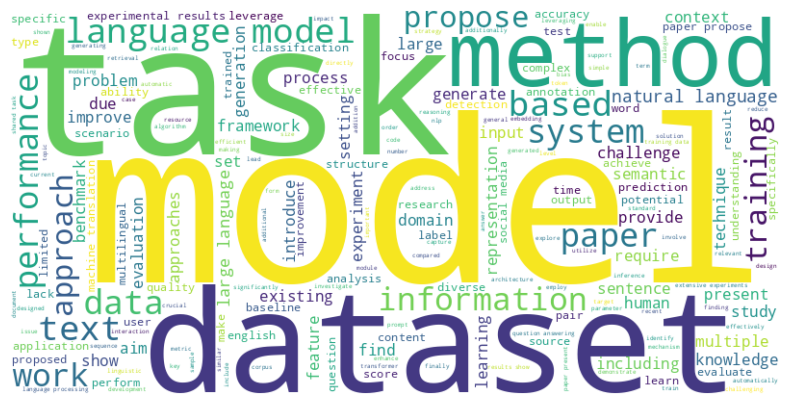

In [ ]:
# analise utilizando o YAKE: http://yake.inesctec.pt/
import yake

# YAKE keyword extraction
custom_kw_extractor = yake.KeywordExtractor(lan="en", n=3, dedupLim=0.9, dedupFunc='seqm', windowsSize=1, top=20, features=None)
df['Keywords'] = df['Processed_Abstract'].apply(lambda x: ', '.join([kw for kw, score in custom_kw_extractor.extract_keywords(x)]))

# Visualize YAKE keywords
yake_keywords = ' '.join(df['Keywords'])
wordcloud_yake = WordCloud(width=800, height=400, background_color='white').generate(yake_keywords)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_yake, interpolation='bilinear')
plt.axis('off')
plt.show()

# LDA Analysis

In [8]:
# Analise utilizando modelagem de tópicos
#https://blog.devgenius.io/working-with-pyldavis-topic-modeling-exploration-tool-b03682d57079
!pip install pyldavis

In [26]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from gensim import matutils
from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.gensim

from pprint import pprint

# Creating a bag-of-words vectorizer
# We cut low and high frequency words and filter out English stopwords
vectorizer = CountVectorizer(min_df=10, max_df=0.5, stop_words="english")
dtm = vectorizer.fit_transform(df['Processed_Abstract'])

def tokenize(text):
    return nltk.word_tokenize(text)

# Apply the tokenization function to each abstract
df['Tokenized_Abstract'] = df['Processed_Abstract'].apply(tokenize)

# Create a dictionary
id2word = Dictionary(df['Tokenized_Abstract'])

# Create a corpus
corpus = [id2word.doc2bow(tokens) for tokens in df['Tokenized_Abstract']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
from gensim.models.ldamodel import LdaModel

# Build LDA model
lda_model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=10,
                   random_state=100,
                   update_every=1,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
# Print the Keyword
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.243*"translation" + 0.091*"machine" + 0.067*"mt" + 0.034*"translations" + '
  '0.027*"nmt" + 0.020*"parallel" + 0.020*"bleu" + 0.017*"neural" + '
  '0.017*"comments" + 0.009*"pairs"'),
 (1,
  '0.026*"data" + 0.025*"model" + 0.013*"performance" + 0.013*"training" + '
  '0.013*"learning" + 0.013*"task" + 0.012*"approach" + 0.012*"results" + '
  '0.012*"models" + 0.011*"paper"'),
 (2,
  '0.027*"language" + 0.025*"models" + 0.021*"et" + 0.013*"languages" + '
  '0.012*"dataset" + 0.011*"research" + 0.010*"corpus" + 0.009*"english" + '
  '0.009*"analysis" + 0.009*"task"'),
 (3,
  '0.121*"de" + 0.047*"des" + 0.043*"les" + 0.040*"la" + 0.026*"à" + '
  '0.023*"nous" + 0.023*"en" + 0.023*"un" + 0.021*"une" + 0.021*"pour"'),
 (4,
  '0.075*"legal" + 0.063*"event" + 0.047*"dialogue" + 0.027*"events" + '
  '0.024*"primary" + 0.018*"causal" + 0.016*"conversations" + '
  '0.016*"scientific" + 0.016*"persuasion" + 0.014*"artificial"'),
 (5,
  '0.018*"models" + 0.017*"knowledge" + 0.010*"topic

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
#Creating Topic Distance Visualization
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.245195  0.026562       1        1  33.688053
2      0.219752 -0.001540       2        1  22.777826
5      0.207448  0.013656       3        1  16.936256
6      0.129424 -0.005283       4        1   8.194112
9      0.066849 -0.014244       5        1   6.147011
3     -0.212177  0.400923       6        1   4.148864
8     -0.055444 -0.048987       7        1   2.836676
0     -0.170004 -0.114530       8        1   1.982334
7     -0.226372 -0.138193       9        1   1.818131
4     -0.204671 -0.118364      10        1   1.470736, topic_info=             Term         Freq        Total Category  logprob  loglift
290   translation  2820.000000  2820.000000  Default  30.0000  30.0000
1809           de  2840.000000  2840.000000  Default  29.0000  29.0000
2505            l  2475.000000  2475.000000  Default  28.0000  28.0000
262       machine  1724.000000  1724.000000  Default  27.0000  27.0000
237     detection  1364.000000  1364.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2753   scientific   134.780460   260.170589  Topic10  -4.1211   3.5617
208      response    70.150390   111.589257  Topic10  -4.7741   3.7552
3895        roles    47.458497    67.055218  Topic10  -5.1649   3.8737
967          turn    44.416699    76.262998  Topic10  -5.2311   3.6788
141        system    43.278153  2083.729818  Topic10  -5.2571   0.3451

[576 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
67         1  0.190443  ability
67         2  0.098293  ability
67         3  0.655288  ability
67         4  0.045051  ability
67         5  0.006143  ability
...      ...       ...      ...
6055       8  0.488896     year
18745      2  0.001631        à
18745      5  0.006522        à
18745      6  0.989789        à
18745      7  0.001631        à

[1358 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 6, 7, 10, 4, 9, 1, 8, 5])